In [10]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
import osmnx as ox
import geopandas as gpd
import networkx as nx

In [11]:
# 1. 数据准备和区域选择
# 加载多个年份的事故数据
files = ['leeds2015.csv', 'leeds2016.csv',
         'leeds2017.csv', 'leeds2018.csv', 'leeds2019.csv']
accidents = pd.concat([pd.read_csv(f, encoding='latin1') for f in files])


In [12]:
# OSGB36 (EPSG:27700) 转 WGS84 (EPSG:4326)
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
accidents['Longitude'], accidents['Latitude'] = transformer.transform(
    accidents['Grid Ref: Easting'].values, 
    accidents['Grid Ref: Northing'].values
)


In [13]:
# 选取事故密集区域 (约1平方公里)，这里示例取中心区域
center_point = accidents[['Latitude', 'Longitude']].mean()
print(f"Center coordinates: {center_point}")

# 确认1平方公里区域内的事故数量（半径约0.005° ≈ 500米）
accidents_center = accidents[
    (accidents['Latitude'] <= center_point['Latitude'] + 0.005) &
    (accidents['Latitude'] >= center_point['Latitude'] - 0.005) &
    (accidents['Longitude'] <= center_point['Longitude'] + 0.005) &
    (accidents['Longitude'] >= center_point['Longitude'] - 0.005)
]

print(f"Selected area accidents: {len(accidents_center)}")


Center coordinates: Latitude     53.80239
Longitude    -1.54534
dtype: float64
Selected area accidents: 236


In [14]:
# 根据确定区域获取道路网络
G = ox.graph_from_point((center_point['Latitude'], center_point['Longitude']),
                        dist=500, network_type='drive')
print(f"Network has {len(G.nodes())} nodes and {len(G.edges())} edges.")


Network has 146 nodes and 242 edges.


In [23]:

# 已经定义好的G
# 投影图到米制坐标系统
G_proj = ox.project_graph(G)

# 转换为GeoDataFrame
nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj)

# 计算凸包面积 (单位: km²)
area_polygon = nodes_proj.unary_union.convex_hull
area_km2 = area_polygon.area / 1e6

print(f"Network area: {area_km2:.4f} km²")

# 基本统计信息
stats = ox.basic_stats(G_proj)

# 提取关键指标
n_nodes = stats['n']
n_edges = stats['m']
average_street_length = stats['street_length_avg']

intersection_count = stats['intersection_count']

node_density = n_nodes / area_km2
intersection_density = intersection_count / area_km2
edge_density = n_edges / area_km2

print(f"Number of nodes: {n_nodes}")
print(f"Number of edges: {n_edges}")
print(f"Average street length: {average_street_length:.2f} m")
print(f"Node density: {node_density:.2f} nodes/km²")
print(f"Intersection density: {intersection_density:.2f} intersections/km²")
print(f"Edge density: {edge_density:.2f} edges/km²")

# 空间直径
diameter = nx.diameter(nx.to_undirected(G_proj))
print(f"Spatial diameter: {diameter}")


Network area: 0.7721 km²
Number of nodes: 146
Number of edges: 242
Average street length: 75.36 m
Node density: 189.09 nodes/km²
Intersection density: 169.66 intersections/km²
Edge density: 313.42 edges/km²
Spatial diameter: 22


C:\Users\10142\AppData\Local\Temp\ipykernel_17412\1125410252.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_polygon = nodes_proj.unary_union.convex_hull


In [24]:
is_planar, _ = nx.check_planarity(nx.to_undirected(G))
print(f"Network planar: {'Yes' if is_planar else 'No'}")


Network planar: No


In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
from pyproj import Transformer
import numpy as np
from libpysal.weights import DistanceBand
from esda.moran import Moran
from pointpats import PointPattern

In [28]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
from pyproj import Transformer
import numpy as np
from libpysal.weights import DistanceBand
from esda.moran import Moran
from pointpats import PointPattern

# 加载所有事故数据
# 正确加载多个CSV文件（考虑latin1编码）
files = ['leeds2015.csv', 'leeds2016.csv',
         'leeds2017.csv', 'leeds2018.csv', 'leeds2019.csv']

accidents = pd.concat(
    [pd.read_csv(f, encoding='latin1') for f in files],
    ignore_index=True
)

# 转换OSGB36坐标到WGS84
transformer = Transformer.from_crs("epsg:27700", "epsg:4326", always_xy=True)
accidents['Longitude'], accidents['Latitude'] = transformer.transform(
    accidents['Grid Ref: Easting'].values,
    accidents['Grid Ref: Northing'].values
)

# 定义1平方公里的分析区域
center_point = accidents[['Latitude', 'Longitude']].mean()
accidents_center = accidents[
    (accidents['Latitude'] <= center_point['Latitude'] + 0.005) &
    (accidents['Latitude'] >= center_point['Latitude'] - 0.005) &
    (accidents['Longitude'] <= center_point['Longitude'] + 0.005) &
    (accidents['Longitude'] >= center_point['Longitude'] - 0.005)
]

# 转换为GeoDataFrame
accidents_gdf = gpd.GeoDataFrame(accidents_center,
                                 geometry=gpd.points_from_xy(accidents_center.Longitude, accidents_center.Latitude),
                                 crs="EPSG:4326")


In [29]:
# 获取道路网络
G = ox.graph_from_point((center_point['Latitude'], center_point['Longitude']),
                        dist=500, network_type='drive')

# 投影网络到米制坐标系
G_proj = ox.project_graph(G)
nodes_proj, edges_proj = ox.graph_to_gdfs(G_proj)

# 投影事故数据到相同的坐标系
accidents_gdf_proj = accidents_gdf.to_crs(nodes_proj.crs)


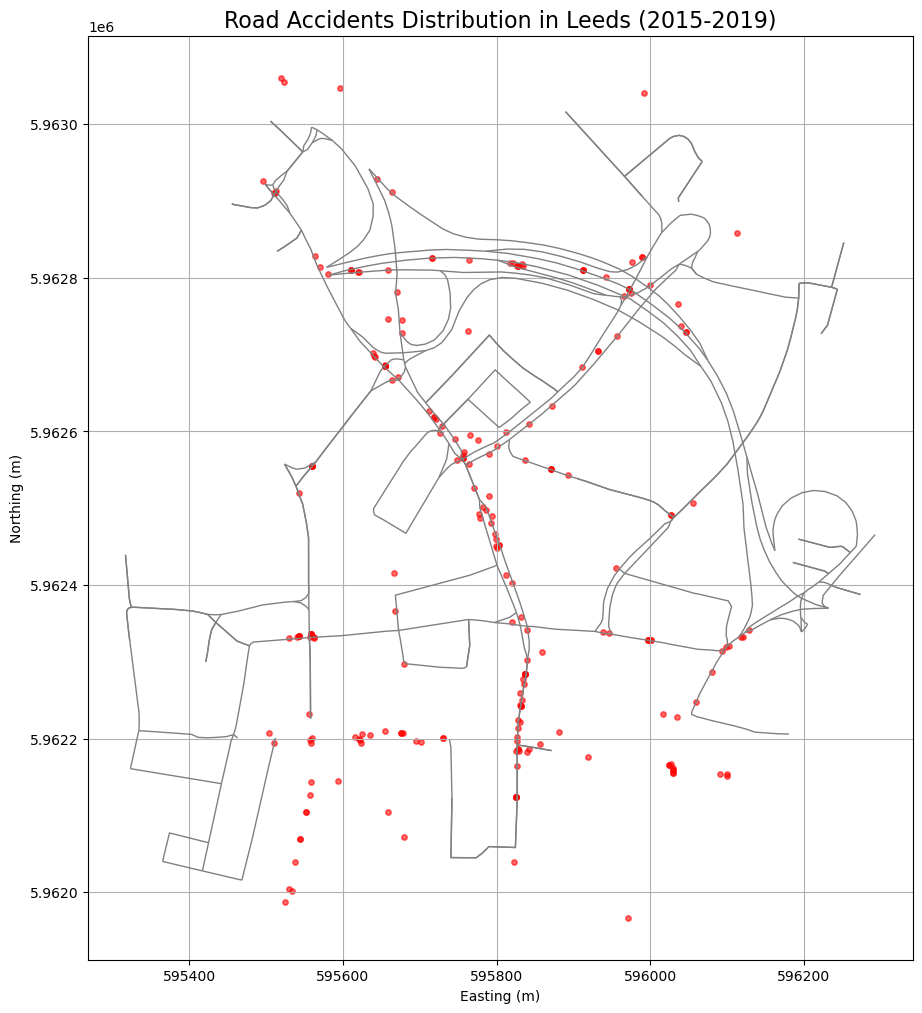

In [30]:
fig, ax = plt.subplots(figsize=(12, 12))
edges_proj.plot(ax=ax, linewidth=1, edgecolor='grey')
accidents_gdf_proj.plot(ax=ax, color='red', markersize=15, alpha=0.6)
plt.title('Road Accidents Distribution in Leeds (2015-2019)', fontsize=16)
plt.xlabel('Easting (m)')
plt.ylabel('Northing (m)')
plt.grid(True)
plt.show()


C:\Users\10142\AppData\Local\Temp\ipykernel_17412\3804558604.py:25: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_m2 = nodes_proj.unary_union.convex_hull.area


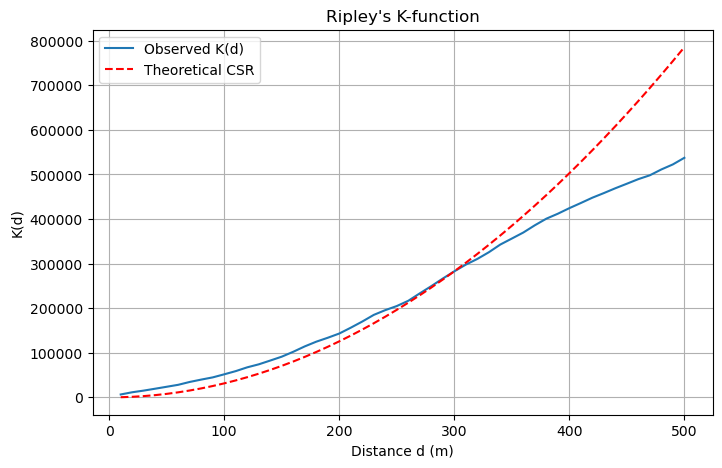

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

def ripley_k(coords, dvals, area):
    """
    coords: N x 2 numpy array of point coordinates
    dvals: distances (e.g., np.arange(10, 500, 10))
    area: area of the study region (m²)
    """
    n = len(coords)
    intensity = n / area  # 点强度 λ
    pdists = distance.pdist(coords)
    k_values = []

    for d in dvals:
        count = np.sum(pdists < d)
        k = count * 2 / (n * intensity)
        k_values.append(k)

    return np.array(k_values)

# 示例输入：accidents_gdf_proj 中的事故坐标
coords = np.array(list(zip(accidents_gdf_proj.geometry.x, accidents_gdf_proj.geometry.y)))
area_m2 = nodes_proj.unary_union.convex_hull.area
dvals = np.arange(10, 501, 10)

k_result = ripley_k(coords, dvals, area_m2)

# 可视化 K 函数结果
plt.figure(figsize=(8, 5))
plt.plot(dvals, k_result, label="Observed K(d)")
plt.plot(dvals, np.pi * dvals**2, 'r--', label="Theoretical CSR")
plt.title("Ripley's K-function")
plt.xlabel("Distance d (m)")
plt.ylabel("K(d)")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
# 构建空间权重矩阵（距离阈值200米）
w = DistanceBand(coords, threshold=200, binary=True, silence_warnings=True)

# 计算每个事故点附近事故数目（用于衡量聚集程度）
accident_counts = np.array([w.cardinalities[i] for i in range(len(coords))])

# Moran’s I 指标计算
moran = Moran(accident_counts, w)

print(f"Moran's I: {moran.I:.4f}")
print(f"P-value: {moran.p_sim:.4f}")
print(f"Z-score: {moran.z_sim:.2f}")


Moran's I: 0.4863
P-value: 0.0010
Z-score: 34.97


C:\Users\10142\AppData\Local\Temp\ipykernel_17412\1548512922.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersections = nodes_proj.geometry.unary_union


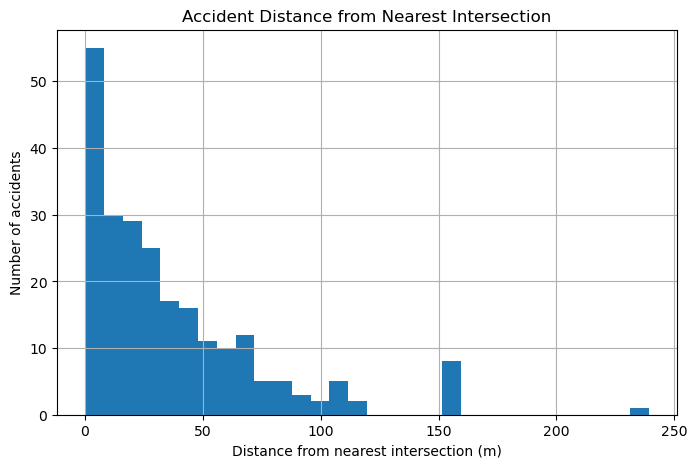

Average distance to nearest intersection: 36.71 m


In [35]:
from shapely.ops import nearest_points

# 提取交叉点
intersections = nodes_proj.geometry.unary_union

# 计算事故点距离最近交叉点距离
accidents_gdf_proj['nearest_intersection_dist'] = accidents_gdf_proj.geometry.apply(
    lambda x: x.distance(nearest_points(x, intersections)[1])
)

# 分析事故点位置分布
plt.figure(figsize=(8,5))
accidents_gdf_proj['nearest_intersection_dist'].hist(bins=30)
plt.xlabel('Distance from nearest intersection (m)')
plt.ylabel('Number of accidents')
plt.title('Accident Distance from Nearest Intersection')
plt.grid(True)
plt.show()

print(f"Average distance to nearest intersection: {accidents_gdf_proj['nearest_intersection_dist'].mean():.2f} m")
